In [2]:
!pip install unrar
!unrar x /content/Dataset2.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Dataset2.rar

Creating    Dataset 2                                                 OK
Creating    Dataset 2/faringitis                                      OK
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.5818f7fd9c45883c801d938b09b29755.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.a04e34f6d58fe952bc090614f030910c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1530jh7bcctf_JPG.rf.b120ee8edff9c00d1f305d865b733a42.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.6bd81eac38835aee94df9c1e5079d67c.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.873f55c8af860852930aef580ce9463d.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1576591844165_jpg.rf.c1c8132c26736bc54117fbc7d64a2714.jpg       0%  OK 
Extracting  Dataset 2/faringitis/1583073772026_jpeg.rf.61c

In [3]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.0 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model, layers, optimizers
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
import pandas as pd
import pathlib
from keras_tuner.tuners import RandomSearch

base_dir = ("/content/Dataset 2")


Found 2460 files belonging to 2 classes.
Kelas yang terdeteksi: ['faringitis', 'normal']
Total batch dataset: 77
Batch train: 53
Batch validation: 15
Batch test: 9
Total gambar di train: 1696
Total gambar di validation: 480
Total gambar di test: 284


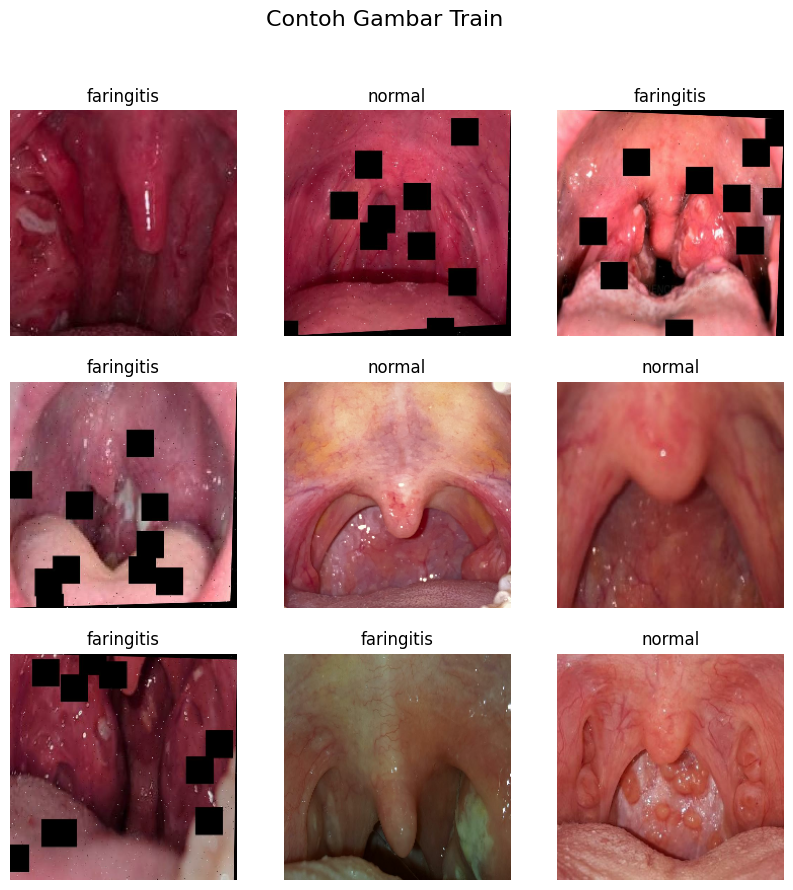

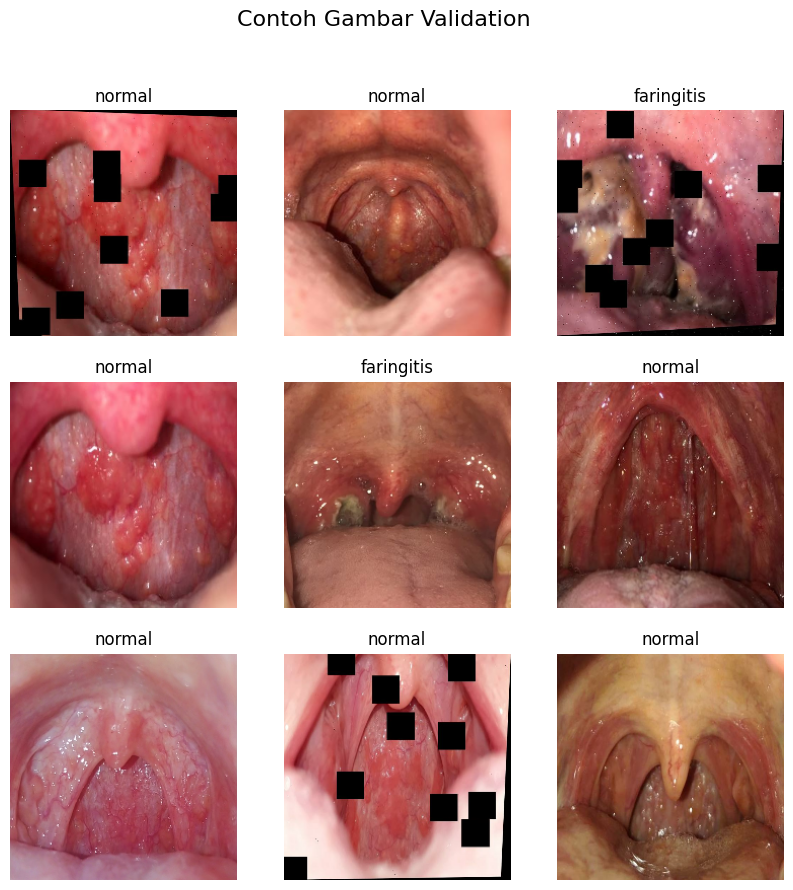

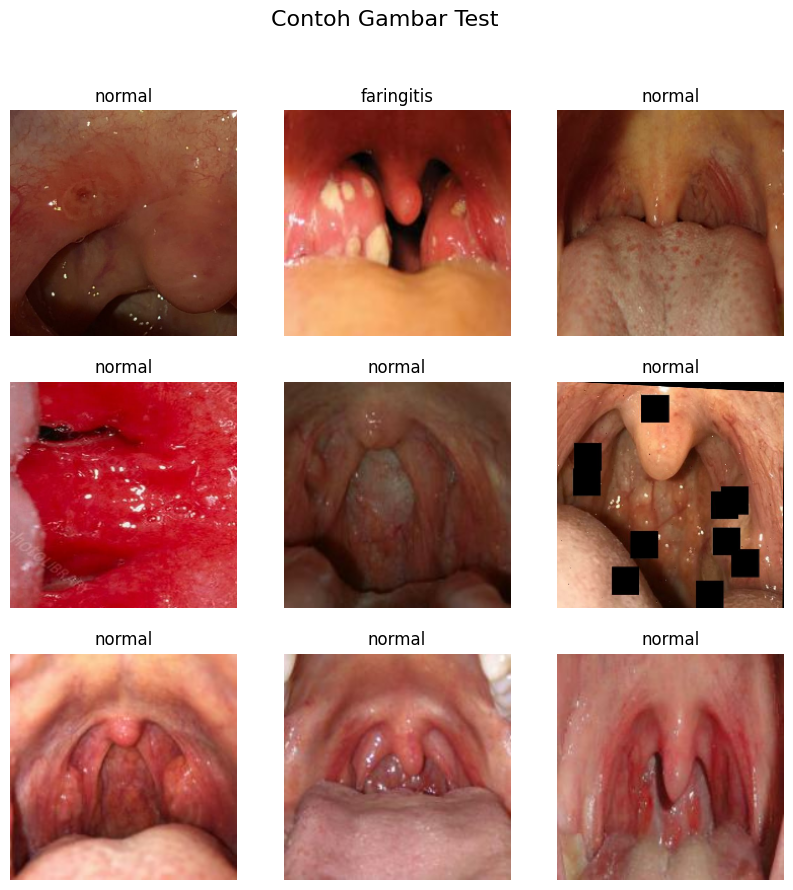

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Path ke dataset
base_dir = "/content/Dataset 2"

# Load dataset dari directory
data = tf.keras.utils.image_dataset_from_directory(
    directory=base_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True
)

# Simpan class names sebelum dimodifikasi
class_names = data.class_names
print("Kelas yang terdeteksi:", class_names)

# Normalisasi pixel ke 0-1
normalization_layer = tf.keras.layers.Rescaling(1./255)
data = data.map(lambda x, y: (normalization_layer(x), y))

# Cek jumlah batch total
dataset_size = len(data)
print(f"Total batch dataset: {dataset_size}")

# Split ukuran
train_size = int(0.7 * dataset_size)
validation_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - validation_size

# Split dataset
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size + validation_size)

print(f"Batch train: {len(train)}")
print(f"Batch validation: {len(validation)}")
print(f"Batch test: {len(test)}")

# Fungsi hitung jumlah gambar di tiap dataset
def count_images(dataset):
    count = 0
    for batch in dataset:
        images, labels = batch
        count += images.shape[0]
    return count

# Hitung total gambar di masing-masing dataset
print(f"Total gambar di train: {count_images(train)}")
print(f"Total gambar di validation: {count_images(validation)}")
print(f"Total gambar di test: {count_images(test)}")

# Fungsi tampilkan contoh gambar dari dataset tertentu
def show_example_images(dataset, class_names, title=""):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(min(9, images.shape[0])):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
        plt.suptitle(title, fontsize=16)
        plt.show()

# Tampilkan gambar contoh dari masing-masing dataset
show_example_images(train, class_names, title="Contoh Gambar Train")
show_example_images(validation, class_names, title="Contoh Gambar Validation")
show_example_images(test, class_names, title="Contoh Gambar Test")


In [6]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]


In [9]:
history = model.fit(
    train,
    epochs=20,
    validation_data=validation,
    callbacks=callbacks
)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step - accuracy: 0.5461 - loss: 0.7523 - val_accuracy: 0.5875 - val_loss: 0.6694
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 239ms/step - accuracy: 0.5418 - loss: 0.7219 - val_accuracy: 0.5979 - val_loss: 0.6479
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - accuracy: 0.5879 - loss: 0.6711 - val_accuracy: 0.6187 - val_loss: 0.6282
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.6103 - loss: 0.6549 - val_accuracy: 0.6479 - val_loss: 0.6156
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.6404 - loss: 0.6403 - val_accuracy: 0.6854 - val_loss: 0.6072
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.6602 - loss: 0.6308 - val_accuracy: 0.6854 - val_loss: 0.5943
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.6820 - loss: 0.6166 - val_accuracy: 0.7396 - val_loss: 0.5688
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.6909 - loss: 0.6123 - val_accu

In [10]:

for layer in base_model.layers:
    if layer.name.startswith('block5_') or layer.name.startswith('block4_'):
        layer.trainable = True


optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 13,110,785 (50.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [12]:
history_finetune = model.fit(
    train,
    epochs=50,
    validation_data=validation,
    callbacks=callbacks
)


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 351ms/step - accuracy: 0.8128 - loss: 0.4475 - val_accuracy: 0.8458 - val_loss: 0.3162
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 355ms/step - accuracy: 0.8960 - loss: 0.2773 - val_accuracy: 0.8813 - val_loss: 0.2473
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 331ms/step - accuracy: 0.9214 - loss: 0.1880 - val_accuracy: 0.8979 - val_loss: 0.2074
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 330ms/step - accuracy: 0.9490 - loss: 0.1247 - val_accuracy: 0.9521 - val_loss: 0.1334
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 331ms/step - accuracy: 0.9678 - loss: 0.0856 - val_accuracy: 0.9292 - val_loss: 0.1495
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 331ms/step - accuracy: 0.9724 - loss: 0.0700 - val_accuracy: 0.9438 - val_loss: 0.1262
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 337ms/step - accuracy: 0.9863 - loss: 0.0449 - val_accuracy: 0.9646 - val_loss: 0.0934
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 329ms/step - accuracy: 0.9905 - loss: 0.0360 - val_accu

In [14]:
test_loss, test_acc = model.evaluate(test)
print(f'Test Accuracy: {test_acc:.4f}')


9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9549 - loss: 0.1323
Test Accuracy: 0.9577


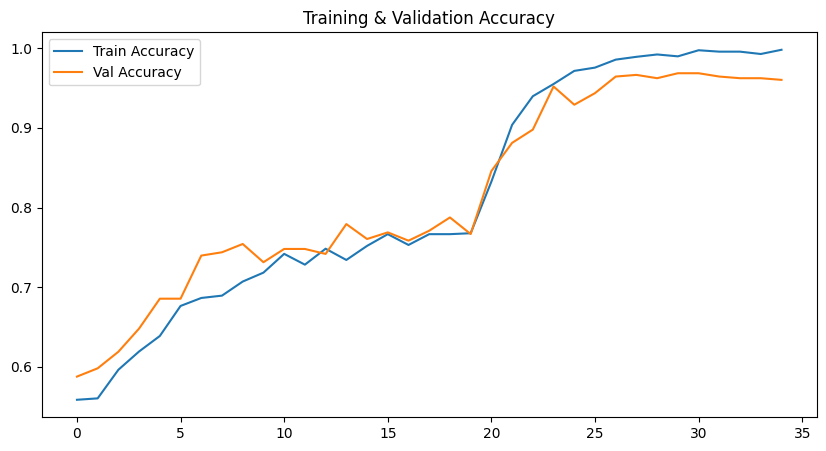

In [15]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()


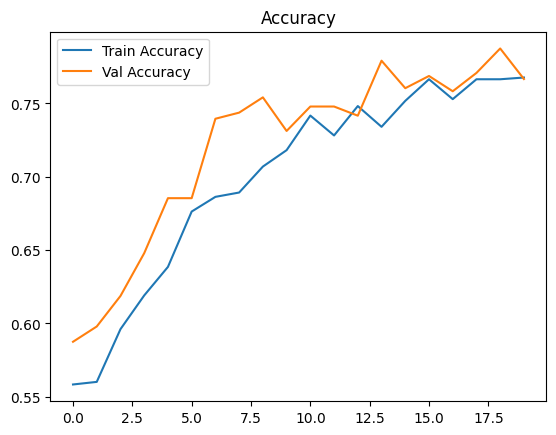

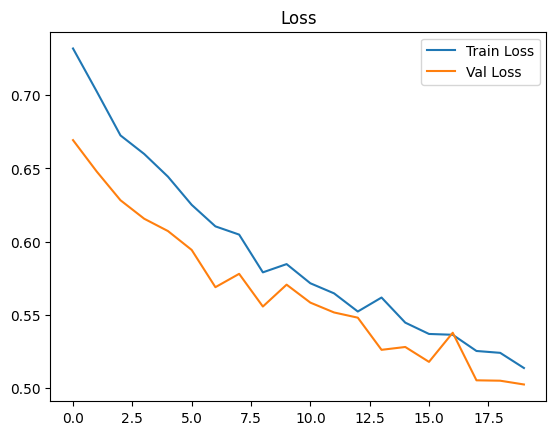

In [21]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [1]:
model.save('VGG16_notuner_noaug.keras')

NameError: name 'model' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


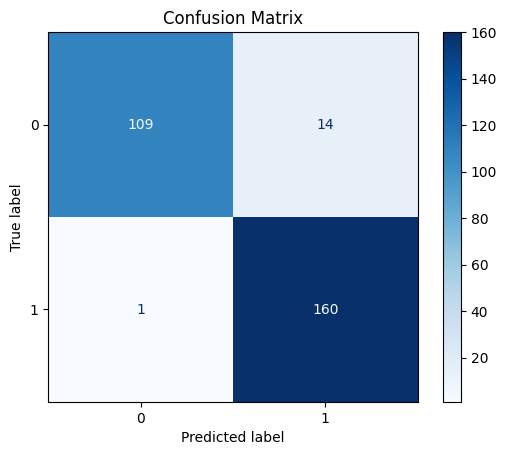

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       123
           1       0.92      0.99      0.96       161

    accuracy                           0.95       284
   macro avg       0.96      0.94      0.95       284
weighted avg       0.95      0.95      0.95       284



In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

true_labels = []
predictions = []

for images, labels in test:  # ← PASTIKAN test_ds bukan di-shuffle
    true_labels.extend(labels.numpy())
    preds = model.predict(images)

    if preds.shape[1] == 1:
        preds = np.round(preds).astype(int).flatten()
    else:
        preds = np.argmax(preds, axis=1)

    predictions.extend(preds)

# Buat confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions))
